### Differential abundance analyses

#### 1. Load required libraries

In [2]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("apeglm")
# install.packages("pheatmap")
library(pheatmap, warn.conflicts = F, quietly = T)
library(ggplot2, warn.conflicts = F, quietly = T)
library(DESeq2, warn.conflicts = F, quietly = T)
library(edgeR, warn.conflicts = F, quietly = T)
library(apeglm, warn.conflicts = F, quietly = T)

ERROR: Error in library(DESeq2, warn.conflicts = F, quietly = T): there is no package called ‘DESeq2’


#### 2. Load data

In [2]:
metadata <- read.table("map.txt", header=T, sep="\t")
row.names(metadata) <- metadata$sample_id
genecounts <- read.table("../02-STAR/homd_mapped/featurecounts/read_counts.txt", header=T, sep="\t", row.names = 1)
# fix sample names gene count file
colnames(genecounts) <- gsub(x = names(genecounts), pattern = "X", replacement = "UF")  
# head(metadata)
# head(genecounts)

#### 3. Format for DESeq2 analysis

In [3]:
# only compare PD to PE
metadata <- metadata[metadata$tooth_type != "PF",]
# only keep columns found in metadata
genecounts <- genecounts[, colnames(genecounts) %in% row.names(metadata)]
# dim(genecounts)
# create deseq object
star_results <- DESeqDataSetFromMatrix(countData = genecounts, colData = metadata, design = ~tooth_type)
# filter out any genes with fewer than 10 reads total
star_results <- star_results[rowSums(counts(star_results)) >= 10,]
star_results
# set factor level (this determines which direction the comparisions are made -- by default it's by alphabetical order)
star_results$tooth_type <- factor(star_results$tooth_type, levels=c("PD", "PE"))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 769594 37 
metadata(1): version
assays(1): counts
rownames(769594): SEQF1003_00001 SEQF1003_00002 ... SEQF3047_02140
  SEQF3049_00253
rowData names(0):
colnames(37): UF10PD UF115PD ... UF69PD UF76PDR
colData names(2): sample_id tooth_type

#### 4. Run DESeq2

In [4]:
ptm <- proc.time()
se_star <- DESeq(star_results)
proc.time() - ptm # this takes about an hour to complete
# compute normalized counts (log2 transformed); + 1 is a count added to avoid errors during the log2 transformation: log2(0) gives an infinite number, but log2(1) is 0.
# normalized = TRUE: divide the counts by the size factors calculated by the DESeq function
norm_counts <- log2(counts(se_star, normalized = TRUE)+1)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 221442 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



    user   system  elapsed 
3768.559  226.957 3008.829 

In [5]:
# save.image()
res <- results(se_star, alpha=0.01)
# order by p value
res <- res[order(res$padj),]
paste("number of genes with adjusted p value lower than 0.01: ", sum(res$padj < 0.01, na.rm=TRUE))
summary(res)

[1] "number of genes with adjusted p value lower than 0.01:  31682"


out of 763258 with nonzero total read count
adjusted p-value < 0.01
LFC > 0 (up)       : 8161, 1.1%
LFC < 0 (down)     : 23521, 3.1%
outliers [1]       : 0, 0%
low counts [2]     : 361329, 47%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [6]:
resultsNames(se_star)

[1] "Intercept"           "tooth_type_PE_vs_PD"

In [7]:
# filter out low count genes
resLFC <- lfcShrink(se_star, coef="tooth_type_PE_vs_PD", type="apeglm")
resLFC <- resLFC[order(resLFC$padj),]
paste("number of genes with adjusted p value lower than 0.01: ", sum(resLFC$padj < 0.01, na.rm=TRUE))
summary(resLFC)
# write results to file
write.table(resLFC, file="deseq_results_pdvpe.txt", quote=F, sep="\t")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] "number of genes with adjusted p value lower than 0.01:  29839"


out of 763258 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 36053, 4.7%
LFC < 0 (down)     : 50570, 6.6%
outliers [1]       : 0, 0%
low counts [2]     : 257790, 34%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



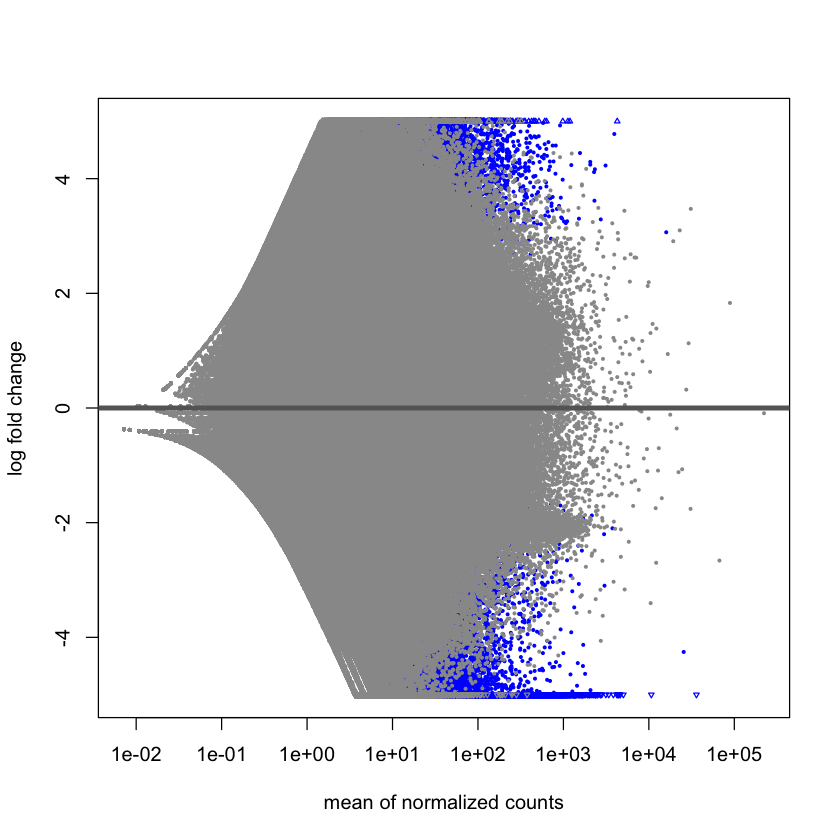

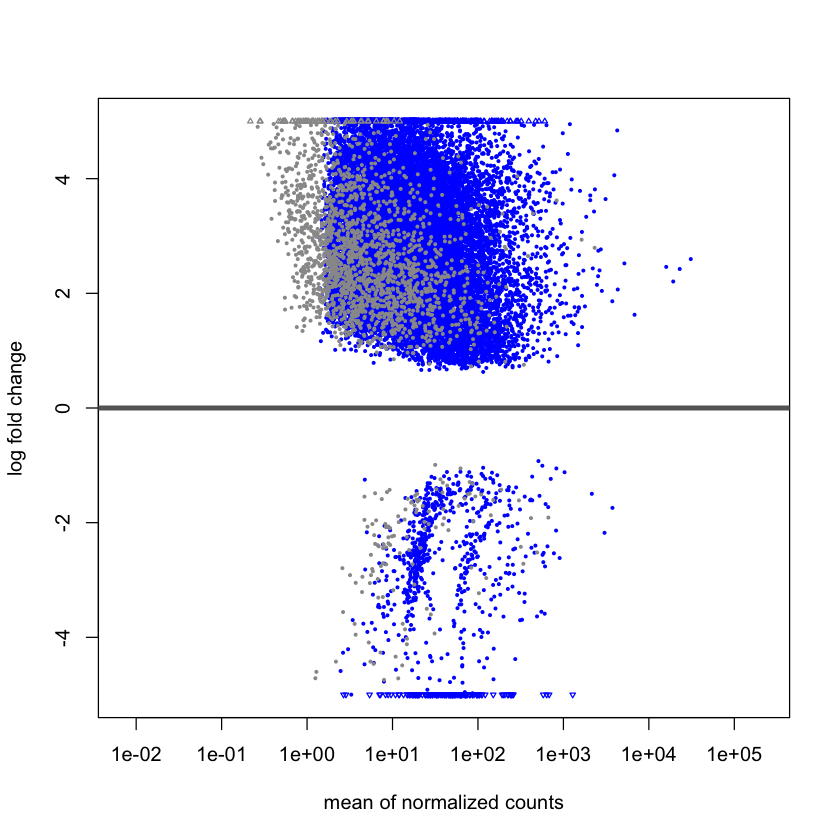

In [8]:
plotMA(res, ylim=c(-5,5))
plotMA(resLFC, ylim=c(-5,5))

In [9]:
# transform for visualizations
vld <- vst(se_star)

pdf 
  2

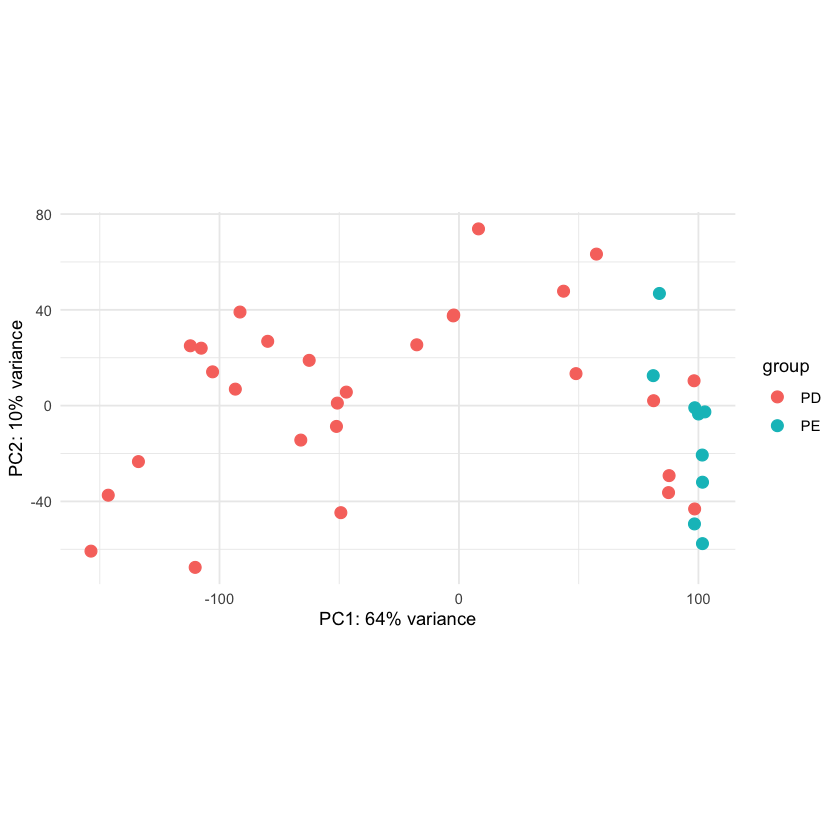

In [10]:
#Get 25 top varying genes
topVarGenes <- head(order(rowVars(assay(vld)), decreasing=TRUE), 25)
 
#make a subset of the log transformed counts for just the top 25 varying genes
top25Counts <- assay(vld)[topVarGenes,]
write.csv(top25Counts, file="top25counts.vld.pdvpe.csv", quote=FALSE)
 
#PLOT PCA
#PCA using top 500 varying genes
pdf("pca_pdvpe.pdf")
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()
dev.off()
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()

pdf 
  2

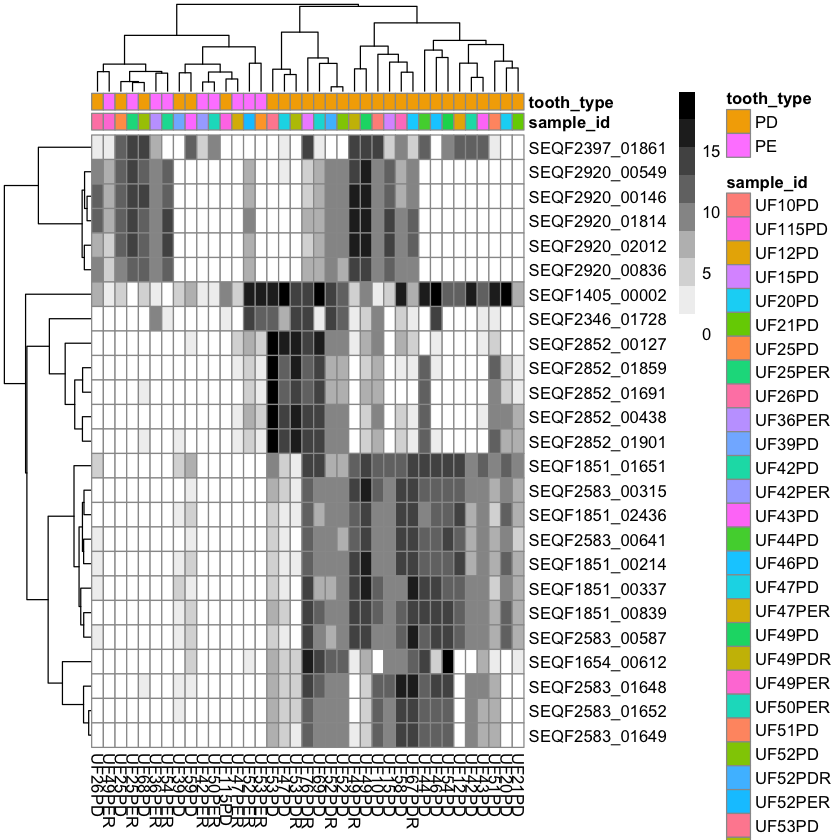

In [13]:
# will have to change sample_id to something more meaningful in final run
df <- as.data.frame(colData(vld)[,c("sample_id","tooth_type")])
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
library(RColorBrewer)
x <- pheatmap(top25Counts, annotation_col = df, color = brewer.pal(9, "Greys"))
save_pheatmap_pdf(x, "heatmap_pdvpe.pdf")